In [3]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_impala import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
ordered_layer_names = {
 0: 'conv_seqs',
 1: 'conv_seqs.0',
 2: 'conv_seqs.0.conv',
 3: 'conv_seqs.0.max_pool2d',
 4: 'conv_seqs.0.res_block0',
 5: 'conv_seqs.0.res_block0.conv0',
 6: 'conv_seqs.0.res_block0.conv1',
 7: 'conv_seqs.0.res_block1',
 8: 'conv_seqs.0.res_block1.conv0',
 9: 'conv_seqs.0.res_block1.conv1',
 10: 'conv_seqs.1',
 11: 'conv_seqs.1.conv',
 12: 'conv_seqs.1.max_pool2d',
 13: 'conv_seqs.1.res_block0',
 14: 'conv_seqs.1.res_block0.conv0',
 15: 'conv_seqs.1.res_block0.conv1',
 16: 'conv_seqs.1.res_block1',
 17: 'conv_seqs.1.res_block1.conv0',
 18: 'conv_seqs.1.res_block1.conv1',
 19: 'conv_seqs.2',
 20: 'conv_seqs.2.conv',
 21: 'conv_seqs.2.max_pool2d',
 22: 'conv_seqs.2.res_block0',
 23: 'conv_seqs.2.res_block0.conv0',
 24: 'conv_seqs.2.res_block0.conv1',
 25: 'conv_seqs.2.res_block1',
 26: 'conv_seqs.2.res_block1.conv0',
 27: 'conv_seqs.2.res_block1.conv1',
 28: 'hidden_fc',
 29: 'logits_fc',
 30: 'value_fc'
}

In [15]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()

    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])


    model = helpers.load_model(model_path=model_path)
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), [ordered_layer_names[layer_number]])
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), [ordered_layer_names[layer_number]])

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    if save_gif:
        helpers.plot_single_observation(observations_steering[-1])
    state = heist.state_from_venv(venv, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)

    return total_reward_steering, state_vals



In [16]:
model_path = "../model_final.pt"
modification_value = -2
total_episodes = 50
best_layer = None
best_score = 0
layer_number = 14


takes_everything_but_rewards = 0
skips_some_other_objective_along_with_rewards = 0
skips_rewards = 0
for episode in range(total_episodes):
    filepath=f'episode_steering_{episode}.gif'
    total_reward_steering, state_vals = run_gem_steering_experiment(model_path, layer_number, modification_value, save_gif=False)
    print(total_reward_steering)
    

    has_keys = False
    has_locks = False
    key_details = []
    lock_details = []

    
    KEY_COLORS = {0: 'blue', 1: 'green', 2: 'red'}

    # Loop through all entities to check if they are keys or locks
    for entity in state_vals["ents"]:
        if entity["image_type"].val == 2:  # image_type 2 for keys
            has_keys = True
            key_color = KEY_COLORS.get(entity["image_theme"].val, "Unknown")
            key_details.append({"position": (entity["x"].val, entity["y"].val), "color": key_color})
        elif entity["image_type"].val == 1:  # image_type 1 for locks
            has_locks = True
            lock_color = KEY_COLORS.get(entity["image_theme"].val, "Unknown")
            lock_details.append({"position": (entity["x"].val, entity["y"].val), "color": lock_color})

    if not has_locks:
        key_details = []
        has_keys = False

    #print("details about the key details", has_keys, key_details)
    #print("details about the lock details", has_locks, lock_details)
    #print("details about reward steering", total_reward_steering)
    if total_reward_steering == 0 and not has_keys and not has_locks:
        takes_everything_but_rewards += 1
    if total_reward_steering == 0 and (has_keys or has_locks):
        skips_some_other_objective_along_with_rewards += 1
    if total_reward_steering != 0:
        skips_rewards += 1


print(f"Takes everything but rewards but out of total episodes: {takes_everything_but_rewards}/{total_episodes}")
print(f"Skips rewards along with some other objectives of total episodes: {skips_some_other_objective_along_with_rewards}/{total_episodes}")
print(f"Skips rewards of total episodes:{skips_rewards}/{total_episodes}")

[]
[0.]
details about the key details False []
details about the lock details False []
details about reward steering [0.]
[]
[0.]
details about the key details False []
details about the lock details False []
details about reward steering [0.]
[{'x': StateValue(val=4.5, idx=13784), 'y': StateValue(val=1.5, idx=13788), 'vx': StateValue(val=0.0, idx=13792), 'vy': StateValue(val=0.0, idx=13796), 'rx': StateValue(val=0.5, idx=13800), 'ry': StateValue(val=0.5, idx=13804), 'type': StateValue(val=1, idx=13808), 'image_type': StateValue(val=1, idx=13812), 'image_theme': StateValue(val=1, idx=13816), 'render_z': StateValue(val=0, idx=13820), 'will_erase': StateValue(val=0, idx=13824), 'collides_with_entities': StateValue(val=0, idx=13828), 'collision_margin': StateValue(val=0.0, idx=13832), 'rotation': StateValue(val=0.0, idx=13836), 'vrot': StateValue(val=0.0, idx=13840), 'is_reflected': StateValue(val=0, idx=13844), 'fire_time': StateValue(val=-1, idx=13848), 'spawn_time': StateValue(val=-1, 

[{'x': StateValue(val=5.5, idx=13830), 'y': StateValue(val=7.5, idx=13834), 'vx': StateValue(val=0.0, idx=13838), 'vy': StateValue(val=0.0, idx=13842), 'rx': StateValue(val=0.5, idx=13846), 'ry': StateValue(val=0.5, idx=13850), 'type': StateValue(val=1, idx=13854), 'image_type': StateValue(val=1, idx=13858), 'image_theme': StateValue(val=0, idx=13862), 'render_z': StateValue(val=0, idx=13866), 'will_erase': StateValue(val=0, idx=13870), 'collides_with_entities': StateValue(val=0, idx=13874), 'collision_margin': StateValue(val=0.0, idx=13878), 'rotation': StateValue(val=0.0, idx=13882), 'vrot': StateValue(val=0.0, idx=13886), 'is_reflected': StateValue(val=0, idx=13890), 'fire_time': StateValue(val=-1, idx=13894), 'spawn_time': StateValue(val=-1, idx=13898), 'life_time': StateValue(val=0, idx=13902), 'expire_time': StateValue(val=-1, idx=13906), 'use_abs_coords': StateValue(val=0, idx=13910), 'friction': StateValue(val=1.0, idx=13914), 'smart_step': StateValue(val=0, idx=13918), 'avoids

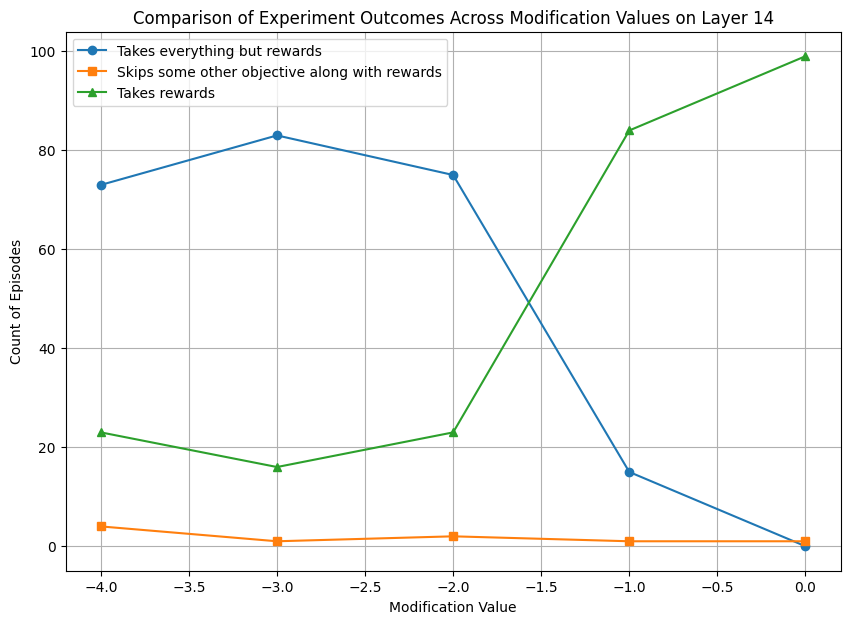

In [20]:
def experiment_comparison(model_path, total_episodes, modification_values):
    results = {}
    KEY_COLORS = {0: 'blue', 1: 'green', 2: 'red'}

    # Iterate through modification values
    for modification_value in modification_values:
        takes_everything_but_rewards = 0
        skips_some_other_objective_along_with_rewards = 0
        takes_rewards = 0
        
        for episode in range(total_episodes):
            total_reward_steering, state_vals = run_gem_steering_experiment(model_path, layer_number, modification_value)

            has_keys = False
            has_locks = False

            # Loop through all entities to check if they are keys or locks
            for entity in state_vals["ents"]:
                if entity["image_type"].val == 2:  # image_type 2 for keys
                    has_keys = True
                elif entity["image_type"].val == 1:  # image_type 1 for locks
                    has_locks = True
            if not has_locks:
                has_keys = False  #the keys are only displayed on the image as a score

            if total_reward_steering == 0 and not has_keys and not has_locks:
                takes_everything_but_rewards += 1
            if total_reward_steering == 0 and (has_keys or has_locks):
                skips_some_other_objective_along_with_rewards += 1
            if total_reward_steering != 0:
                takes_rewards += 1

        # Store results for each modification value
        results[modification_value] = {
            "takes_everything_but_rewards": takes_everything_but_rewards,
            "skips_some_other_objective_along_with_rewards": skips_some_other_objective_along_with_rewards,
            "takes_rewards": takes_rewards
        }

    # Plot the results
    plt.figure(figsize=(10, 7))
    mod_values = list(results.keys())
    tebr = [results[m]["takes_everything_but_rewards"] for m in mod_values]
    ssooar = [results[m]["skips_some_other_objective_along_with_rewards"] for m in mod_values]
    sr = [results[m]["takes_rewards"] for m in mod_values]

    plt.plot(mod_values, tebr, marker='o', label='Takes everything but rewards')
    plt.plot(mod_values, ssooar, marker='s', label='Skips some other objective along with rewards')
    plt.plot(mod_values, sr, marker='^', label='Takes rewards')
    
    plt.title("Comparison of Experiment Outcomes Across Modification Values on Layer 14")
    plt.xlabel("Modification Value")
    plt.ylabel("Count of Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
model_path = "../model_final.pt"
total_episodes = 100
modification_values = range(0, -5, -1)  # From 0 to -5
experiment_comparison(model_path, total_episodes, modification_values)